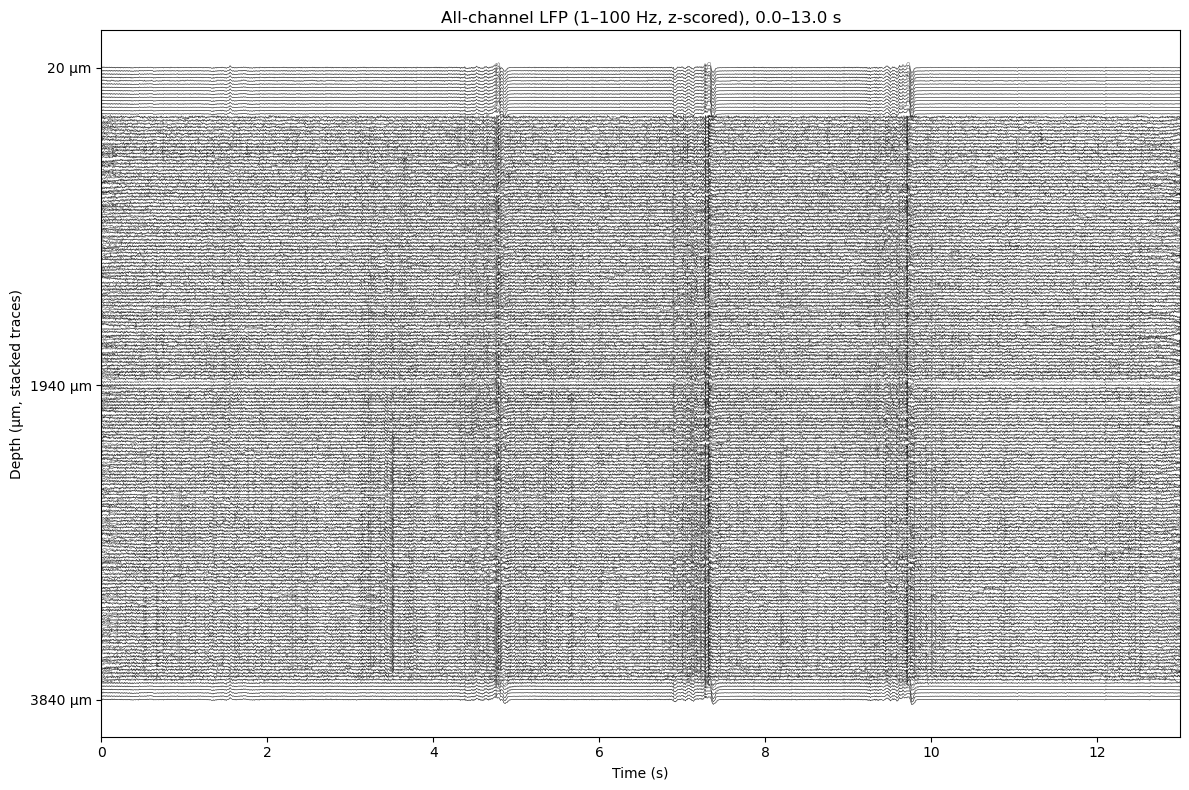

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, filtfilt, decimate

# ------------- configure -------------
phy_dir = Path(r"C:\Users\Ben\Desktop\Contra Pinch\A3")
ap_dir  = Path(r"E:\NEURPIXELS_SALLY\practice3_SZMB_jawpinch_contra_final_2024-11-21_16-13-07\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-AP")

t0   = 0.0      # start time (s) in the spike/Phy clock
twin = 13.0      # window length (s)
max_ch = None   # set to an int (e.g., 192) to cap plotted channels
# -------------------------------------

# ---- spike zero for clock anchoring ----
spike_times = np.load(phy_dir/'spike_times.npy')
spike_fs = 30000.0
try:
    txt = (phy_dir/'params.py').read_text()
    for line in txt.splitlines():
        if 'sample_rate' in line and '=' in line:
            spike_fs = float(line.split('=')[-1]); break
except Exception:
    pass
spike_zero = float(spike_times.min()/spike_fs)

# ---- derive LFP from AP, align to spike zero ----
sn_ap = np.load(ap_dir/'sample_numbers.npy')
n_samples_ap = sn_ap.size
bytes_total_ap = (ap_dir/'continuous.dat').stat().st_size
n_channels_ap = bytes_total_ap // (n_samples_ap*2)     # int16 -> 2 bytes
mm_ap = np.memmap(ap_dir/'continuous.dat', dtype='int16', mode='r')
ap = np.reshape(mm_ap, (n_samples_ap, n_channels_ap)).astype('float32')

fs_ap = 30000.0
# low-pass to 300 Hz, then decimate ×30 (~1 kHz)
b, a = butter(3, 300.0/(fs_ap/2), btype='low')
ap_lp = filtfilt(b, a, ap, axis=0)
dec = 30
lfp = decimate(ap_lp, dec, axis=0, ftype='fir', zero_phase=True)
t_lfp = (sn_ap.astype(float)/fs_ap)[::dec][:lfp.shape[0]]

# align to spike zero so LFP clock starts with Phy
t_lfp -= float(t_lfp[0])
t_lfp += spike_zero

# ---- pick channels and ordering by depth ----
chan_pos = np.load(phy_dir/'channel_positions.npy')  # (n_channels_ap, 2)
depths = chan_pos[:,1]
order = np.argsort(depths)                           # shallow -> deep
if max_ch is not None:
    # subsample channels uniformly by depth if too many
    step = max(1, len(order)//max_ch)
    order = order[::step]

# ---- select time window on aligned LFP ----
t1 = t0 + twin
sel_t = (t_lfp >= t0) & (t_lfp <= t1)
if not np.any(sel_t):
    raise RuntimeError(f"No LFP samples in window {t0:.2f}–{t1:.2f} s. Check t0/twin.")
t = t_lfp[sel_t]
X = lfp[sel_t][:, order]

# ---- display band-pass and z-score per channel ----
def bandpass(x, fs, lo=1, hi=100, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)
fs_disp = 1000.0  # ~1 kHz after decimation
try:
    Xb = bandpass(X, fs_disp, 1, 100, order=3)
except Exception:
    Xb = X

def zscore2D(M):
    m = np.median(M, axis=0, keepdims=True)
    s = np.std(M, axis=0, keepdims=True)
    s[s==0] = 1.0
    return (M - m) / s
Z = zscore2D(Xb)

# ---- stack and plot: offset by depth (µm) to make a depth map ----
depths_sel = depths[order]
# normalize depth range to a neat spacing (e.g., 40 units per 200 µm)
dmin, dmax = float(np.nanmin(depths_sel)), float(np.nanmax(depths_sel))
depth_norm = (depths_sel - dmin) / max(1.0, (dmax - dmin))
offsets = depth_norm * 10000.0    # vertical span for all channels
gain = 10.0                      # LFP gain per channel (adjust as needed)
Y = Z * gain + offsets  # stacked signals

plt.figure(figsize=(12, 8))
plt.plot(t, Y, color='k', linewidth=0.3, alpha=0.7)
plt.xlim(t0, t1)
yticks_pos = [offsets[0], offsets[len(offsets)//2], offsets[-1]]
yticks_lab = [f"{int(depths_sel[0])} µm", f"{int(depths_sel[len(offsets)//2])} µm", f"{int(depths_sel[-1])} µm"]
plt.yticks(yticks_pos, yticks_lab)
plt.xlabel("Time (s)")
plt.ylabel("Depth (µm, stacked traces)")
plt.title(f"All-channel LFP (1–100 Hz, z‑scored), {t0:.1f}–{t1:.1f} s")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
